# 1.

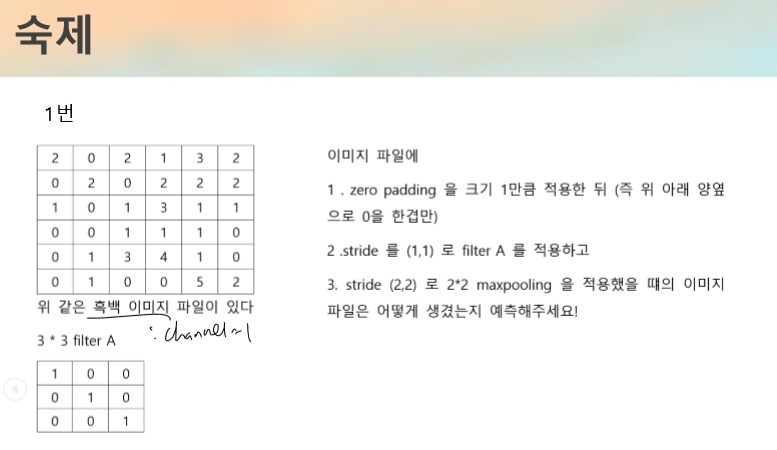

## 1. zero padding을 적용하고 filter matrix를 만들기까지

In [1]:
import numpy as np

# input
input_data = np.array([[2,0,2,1,3,2],   #input is a keyword
            [0,2,0,2,2,2],
            [1,0,1,3,1,1],
            [0,0,1,1,1,0],
            [0,1,3,4,1,0],
            [0,1,0,0,5,2]])

# 한겹 zero pad
padded_data = np.zeros(input_data.shape + np.array([2,2]))
padded_data[1:7,1:7] = input_data
padded_data

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 2., 1., 3., 2., 0.],
       [0., 0., 2., 0., 2., 2., 2., 0.],
       [0., 1., 0., 1., 3., 1., 1., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 3., 4., 1., 0., 0.],
       [0., 0., 1., 0., 0., 5., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

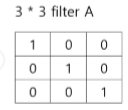

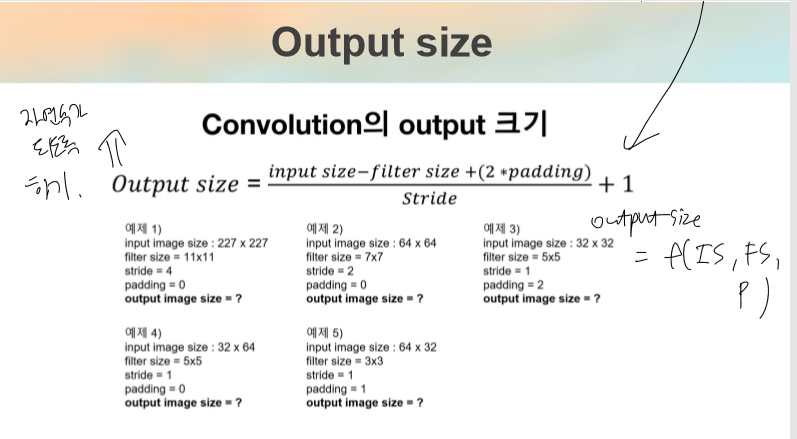

In [2]:
filter_data = np.eye(3) #filter is a keyword

stride = np.array([1,1]) # stride를 1,1로 적용하고 에 해당
padding = np.array([2,2])/2

padding

array([1., 1.])

## 2. convolution

In [3]:
row= int( (input_data.shape[0] - filter_data.shape[0] + 2*padding[0])/stride[0] + 1 )
col= int( (input_data.shape[1] - filter_data.shape[1] + 2*padding[1])/stride[1] + 1 )
print(row,col)

6 6


In [4]:
output = [ ] 

for r in range(row):
    for c in range(col):
        middle = padded_data[r:r + filter_data.shape[0], c:c + filter_data.shape[1]]*filter_data
        output.append(np.sum(middle))
output=np.array(output).reshape(row,col)
output

array([[ 4.,  0.,  4.,  3.,  5.,  2.],
       [ 0.,  5.,  3.,  5.,  4.,  5.],
       [ 1.,  1.,  4.,  4.,  3.,  3.],
       [ 1.,  4.,  5.,  3.,  4.,  1.],
       [ 1.,  1.,  3., 10.,  4.,  1.],
       [ 0.,  1.,  1.,  3.,  9.,  3.]])

## 3. Maxpool

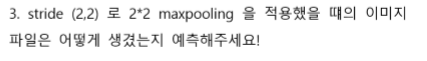



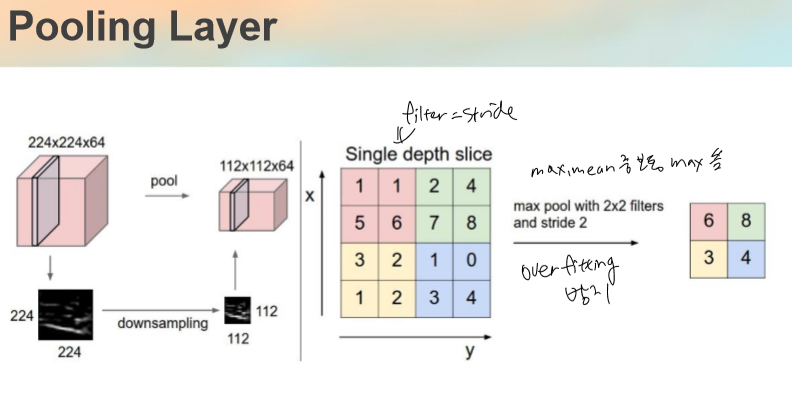

In [5]:
def max_pool(x, stride): # 이문제에서는 x가 6,6인 outputdata이고 stride가 2이다.
    mp =[]
    for i in range(0,len(x)-1,stride):
        for j in range(0,len(x)-1,stride):
            mp.append(np.max(x[i:i+stride, j:j+stride]))  #여기가 중요. 반복적(iterative)으로 2*2 행렬에서 최댓값을 찾는과정이다. 이 줄이 pool layer -> max함수를 나타내는 과정이다.
    
    mp = np.array(mp)
    return mp.reshape(stride+1, stride+1)

In [6]:
output = max_pool(output,2)
output

array([[ 5.,  5.,  5.],
       [ 4.,  5.,  4.],
       [ 1., 10.,  9.]])

# 2.

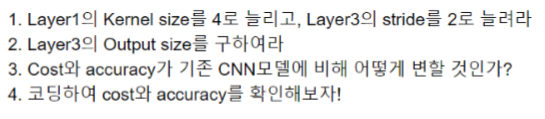

기존 모델은 accuracy가 96%가량, 최종 cost가 0.008 가량이었다.

layer1의 kernel size, layer3의 stride를 늘릴 때 그 두 지표는 어찌 바뀔까?

In [7]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init


device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(2020)
if device == 'cuda':
    torch.cuda.manual_seed_all(2020)
    

hyperparameter tuningparameter를 주관으로 미리 정함. 기존 모델과 같은 parameters

In [8]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [9]:
#load data
mnist_train = dsets.MNIST(root = 'MNIST_data/',
                          train = True, # train이므로
                          transform = transforms.ToTensor(),
                          download = False)

mnist_test = dsets.MNIST(root = 'MNIST_data/',
                         train = False, # test이므로
                         transform = transforms.ToTensor(),
                         download = False)
data_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                     batch_size = batch_size,
                                     shuffle = True,
                                     drop_last = True)

In [14]:
# CNN model을 class로 지정한다.

class CNN2(torch.nn.Module):
    
    def __init__(self):
        super(CNN2, self).__init__()
        self.keep_prob = 0.5 # layer들 간의 각 연결에서 0.5의 확률로 train에 사용된다고 한다.
        # deeplearning 식 overfitting 방식이라 한다.
         # https://stackoverflow.com/questions/35545798/keep-prob-in-tensorflow-mnist-tutorial
        
        
        # convolution : in channel : 1, out channel : 32, kernel size : 4, stride :1, padding : 1
        # maxpool : kernel size : 2, stride : 2
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 4, stride = 1, padding=1), #layer1의 커널사이즈를 4로늘려라
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
 
        # convolution : in channel : 32, out channel : 64, kernel size : 3, stride :1, padding : 1
        # maxpool : kernel size : 2, stride : 2
         
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2))
 
        # convolution : in channel : 64, out channel : 128, kernel size : 3, stride :2, padding : 1
        # maxpool : kernel size : 2, stride : 2
 
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding=1), #layer3의 스트라이드를2로늘려라
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1))

       
         
        self.fc1 = torch.nn.Linear(2*2*128, 625 ,bias = True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 1 - self.keep_prob))
            
        self.fc2 = torch.nn.Linear(625, 10 ,bias = True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
    
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) # 차원을 하나 내려 평평화
        out = self.layer4(out)
        out = self.fc2(out)
        return out

layer 3의 output size 는 2,2,128이다

In [15]:
model = CNN2().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device) #소프트맥스 분류 -> crossentropy 손실
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [16]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [ ]:
# 모델 훈련하기

total_batch = len(data_loader)
print ('윽')
for epoch in range(training_epochs):
    avg_cost = 0
    
    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('[Epoch: {:>4}] cost = {:>.4}'.format(epoch + 1, avg_cost))
print('done')

윽
[Epoch:    1] cost = 0.2419
[Epoch:    2] cost = 0.0613
[Epoch:    3] cost = 0.04358
[Epoch:    4] cost = 0.03379
[Epoch:    5] cost = 0.02727


In [ ]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test =  mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())